# Data Loading and Normalization

In [82]:
# Helper functions for generating category-name mapping for anchors

def map_array_values(array, value_map):
    # value map must be { src : target }
    ret = array.copy()
    for src, target in value_map.items():
        ret[ret == src] = target
    return ret

def replace_binary_values(array, values):
    return map_array_values(array, {'0': values[0], '1': values[1]})

In [83]:
import numpy as np
import pandas as pd
from anchor import utils
from anchor import anchor_tabular

transforms = {
            5: lambda x: replace_binary_values(x, ['No', 'Yes']),
            6: lambda x: replace_binary_values(x, ['New Vehicle', 'Used Vehicle']),
            7: lambda x: replace_binary_values(x, ['No', 'Yes']),
            10: lambda x: replace_binary_values(x, ['No', 'Yes']),
            11: lambda x: replace_binary_values(x, ['No', 'Yes']),
            12: lambda x: replace_binary_values(x, ['No', 'Yes']),
            13: lambda x: replace_binary_values(x, ['No', 'Yes']),
            14: lambda x: replace_binary_values(x, ['No', 'Yes']),
            15: lambda x: replace_binary_values(x, ['No', 'Yes']),
            16: lambda x: replace_binary_values(x, ['No', 'Yes']),
            17: lambda x: replace_binary_values(x, ['No', 'Yes']),
            18: lambda x: replace_binary_values(x, ['No', 'Yes']),
            19: lambda x: replace_binary_values(x, ['No', 'Yes']),
            20: lambda x: replace_binary_values(x, ['No', 'Yes']),
            21: lambda x: replace_binary_values(x, ['No', 'Yes']),
            22: lambda x: replace_binary_values(x, ['Not Defaulted', 'Defaulted']),
        }

In [84]:
# Load dataset using XAI data loader. This will 50/50 class balance the dataset by downsampling,
#create mappings for column categories to explainable names and 80/20 split into train/test
dataset = utils.load_csv_dataset('preprocessed.csv', 22, delimiter=',',
                 categorical_features=[5,6,7,10,11,12,13,14,15,16,17,18,19,20,21],
                 feature_transformations=transforms, discretize=False, balance=True, fill_na=0)

In [85]:
dataset.labels_train.shape

(410900,)

In [86]:
# Add axis for skorch compatability
dataset.labels_train = dataset.labels_train[:, np.newaxis]
dataset.labels_test = dataset.labels_test[:, np.newaxis]

# Cast to floats for skorch compatability
dataset.train = dataset.train.astype(np.float32)
dataset.labels_train = dataset.labels_train.astype(np.float32)
dataset.test = dataset.test.astype(np.float32)
dataset.labels_test = dataset.labels_test.astype(np.float32)

In [87]:
dataset.labels_train.shape

(410900, 1)

In [88]:
# Normalize training and test data using min-max normalization 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
dataset.train = scaler.fit_transform(dataset.train)
dataset.test = scaler.transform(dataset.test)

# Neural Network

Now that the data is prepared, we will use grid search to find good parameters for a neural network.

In [89]:
import torch
# Making the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [90]:
# Neural network module that can accept params we will use in our grid search
import torch.nn as nn
import torch.nn.functional as F

# modules: list of (nn activation funcs or layers) see https://pytorch.org/docs/stable/nn.html
# modules must retain proper input and output shape sequentially
class NetModule(nn.Module):
    def __init__(self, net_modules):
        super(NetModule, self).__init__()
        self.net_modules = nn.Sequential(*net_modules)
        
        
    def forward(self, x):
        x = self.net_modules(x)
        return x

In [91]:
# Set internal dimensions
input_dim = dataset.train.shape[1]
output_dim = 1 # binary classification, default or no default

In [92]:
included_modules = []

# Search Sigmoid activation with different neurons in hidden layer
included_modules.append([nn.Linear(input_dim, 50),
                          nn.Sigmoid(),
                          nn.Linear(50, output_dim)
                          ])

# Search Sigmoid activation with different neurons in hidden layer
included_modules.append([nn.Linear(input_dim, 50),
                          nn.Sigmoid(),
                          nn.Linear(50, 25),
                          nn.ReLU(),
                          nn.Linear(25, output_dim)
                          ])


# Search Sigmoid activation with different neurons in hidden layer
included_modules.append([nn.Linear(input_dim, 75),
                          nn.Sigmoid(),
                          nn.Linear(75, 50),
                          nn.ReLU(),
                          nn.Linear(50, output_dim)
                          ])

# Number of architectures
print(len(included_modules))

3


In [127]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score

from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
import time
import pickle

# Create sklearn scorer for use in architecture search
precision_scorer = make_scorer(precision_score)
early_stop = EarlyStopping(patience=7)

In [94]:
#initialize skorch NN classifier with default params
net = NeuralNetClassifier(
    NetModule,
    criterion= nn.BCEWithLogitsLoss(),
    optimizer=torch.optim.SGD,
    optimizer__momentum=0.95,
    iterator_train__shuffle=True,
    batch_size = len(dataset.train), 
    callbacks=[early_stop],
    device=device
)

In [16]:
# Perform grid search CV and output the best performing parameters

#parameters to test using gridsearch
params = {
    'lr': [0.2], 
    'max_epochs': [100],
    #pass parameters to NetModule constructor to set architecture
    'module__net_modules': included_modules
} 

# Perform grid search with 2-fold cross validation, will refit model at the end using best params on entire training set
gs = GridSearchCV(net, params, refit=True, cv=2, scoring=precision_scorer, verbose=10)

start_time = time.time()
gs.fit(dataset.train, dataset.labels_train)
elapsed_time = time.time() - start_time

model_output = (elapsed_time, gs) 
pickle.dump( model_output, open( "default_model.p", "wb" ) ) 

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2; 1/3] START lr=0.2, max_epochs=100, module__net_modules=[Linear(in_features=22, out_features=50, bias=True), Sigmoid(), Linear(in_features=50, out_features=1, bias=True)]
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7130       0.4996        0.6918  4.2420
      2        0.6918       0.5004        0.6970  2.4060
      3        0.6971       0.5004        0.7115  2.4900
      4        0.7116       0.5004        0.6986  2.4820
      5        0.6987       0.6244        0.6863  2.4751
      6        0.6864       0.4996        0.6982  2.4790
      7        0.6983       0.4996        0.7005  2.3680
      8        0.7007       0.4997        0.6840  2.4301
      9        0.6842       0.5004        0.6822  2.6922
     10        0.6824       0.5004        0.6918  2.5255
     11        0.6920       0.5004        0.6838  2.4760
     12        0.6840

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7129       0.4996        0.6919  2.3140
      2        0.6918       0.5004        0.6971  2.5210
      3        0.6970       0.5004        0.7116  2.6570
      4        0.7115       0.5004        0.6988  2.5610
      5        0.6986       0.6215        0.6865  2.6273
      6        0.6863       0.4996        0.6984  2.7930
      7        0.6982       0.4996        0.7008  2.7150
      8        0.7005       0.4997        0.6843  2.4670
      9        0.6840       0.5004        0.6824  2.5080
     10        0.6822       0.5004        0.6920  2.7229
     11        0.6917       0.5004        0.6840  2.4500
     12        0.6837       0.7221        0.6713  2.5070
     13        0.6709       0.5035        0.6756  2.5080
     14        0.6751       0.5000        0.6778  2.5340
     15        0.6772       0.6282        0.6646  2.5360
     16        0.6640       0.6

      2        0.7030       0.4996        0.6969  2.5130
      3        0.6969       0.4996        0.6937  2.5280
      4        0.6937       0.5004        0.6932  2.4690
      5        0.6932       0.5004        0.6944  2.4770
      6        0.6944       0.5004        0.6962  2.5040
      7        0.6962       0.5004        0.6975  2.5530
      8        0.6975       0.5004        0.6978  2.6041
      9        0.6979       0.5004        0.6971  2.5140
     10        0.6971       0.5004        0.6958  2.4790
Stopping since valid_loss has not improved in the last 7 epochs.
[CV 1/2; 2/3] END lr=0.2, max_epochs=100, module__net_modules=[Linear(in_features=22, out_features=50, bias=True), Sigmoid(), Linear(in_features=50, out_features=25, bias=True), ReLU(), Linear(in_features=25, out_features=1, bias=True)]; total time=  30.5s
[CV 2/2; 2/3] START lr=0.2, max_epochs=100, module__net_modules=[Linear(in_features=22, out_features=50, bias=True), Sigmoid(), Linear(in_features=50, out_features=2

     18        0.6669       0.7417        0.6630  2.4911
     19        0.6625       0.7412        0.6579  2.4812
     20        0.6573       0.7402        0.6518  2.4756
     21        0.6511       0.7401        0.6448  2.4945
     22        0.6439       0.7399        0.6365  2.4950
     23        0.6356       0.7406        0.6270  2.5068
     24        0.6258       0.7404        0.6160  2.5154
     25        0.6147       0.7409        0.6036  2.5219
     26        0.6020       0.7404        0.5899  2.5024
     27        0.5880       0.7415        0.5750  2.4793
     28        0.5729       0.7421        0.5596  2.5111
     29        0.5571       0.7436        0.5441  2.5109
     30        0.5414       0.7451        0.5295  2.4957
     31        0.5264       0.7469        0.5163  2.4953
     32        0.5130       0.7503        0.5051  2.5040
     33        0.5016       0.7537        0.4959  2.4940
     34        0.4922       0.7569        0.4881  2.4825
     35        0.4845       0.7

In [128]:
elapsed, gs = pickle.load( open( "default_model.p", "rb" ) )
print("Best Precision: " + str(gs.best_score_) + "\nBest Parameters: " + str(gs.best_params_))

Best Precision: 0.9756385400492267
Best Parameters: {'lr': 0.2, 'max_epochs': 100, 'module__net_modules': [Linear(in_features=22, out_features=75, bias=True), Sigmoid(), Linear(in_features=75, out_features=50, bias=True), ReLU(), Linear(in_features=50, out_features=1, bias=True)]}


In [129]:
print("Training Time: " + '{0:.5}'.format(elapsed) + ' seconds')

Training Time: 1039.0 seconds


In [130]:
y_pred = gs.predict(dataset.test)
  
print("Precision on Test Data: " + str(precision_score(dataset.labels_test, y_pred)))

Precision on Test Data: 0.9370329057445622


In [131]:
print("Recall on Test Data: " + str(recall_score(dataset.labels_test, y_pred)))

Recall on Test Data: 0.6562506103158018


In [132]:
print("Accuracy: " + str(accuracy_score(dataset.labels_test, y_pred)))

Accuracy: 0.806679905768744


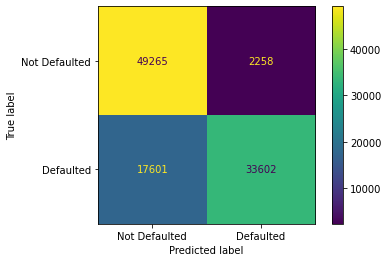

In [133]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


ConfusionMatrixDisplay(confusion_matrix(dataset.labels_test, y_pred), display_labels=["Not Defaulted", "Defaulted"]).plot()

In [134]:
roc = roc_curve(dataset.labels_test, y_pred)

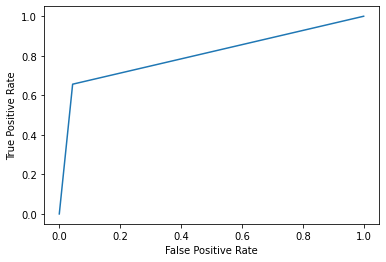

In [136]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay


RocCurveDisplay(fpr=roc[0], tpr=roc[1]).plot()

In [137]:
from sklearn.metrics import roc_auc_score
roc_auc_score(dataset.labels_test, y_pred)

0.8062127612454735

# Logistic Regression

We will now compare the performance of the neural network to the baseline performance of logistic regression.

In [138]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression().fit(dataset.train, dataset.labels_train)
y_pred = log_reg.predict(dataset.test)

print("Precision on Test Data: " + str(precision_score(dataset.labels_test, y_pred)))

c:\users\kevin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Precision on Test Data: 0.8665427430768256


c:\users\kevin\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [139]:
print("Recall on Test Data: " + str(recall_score(dataset.labels_test, y_pred)))

Recall on Test Data: 0.801183524402867


In [140]:
print("Accuracy: " + str(accuracy_score(dataset.labels_test, y_pred)))

Accuracy: 0.8393980102408348


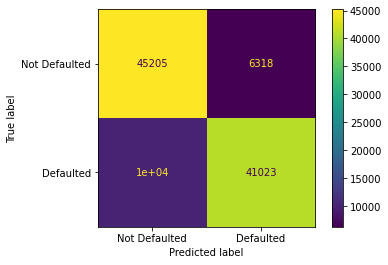

In [141]:
ConfusionMatrixDisplay(confusion_matrix(dataset.labels_test, y_pred), display_labels=["Not Defaulted", "Defaulted"]).plot()

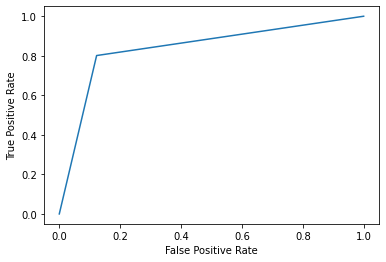

In [142]:
roc = roc_curve(dataset.labels_test, y_pred)
RocCurveDisplay(fpr=roc[0], tpr=roc[1]).plot()

In [143]:
roc_auc_score(dataset.labels_test, y_pred)

0.8392793386236138

# XAI Framework

In [108]:
explainer = anchor_tabular.AnchorTabularExplainer(dataset.class_names, dataset.feature_names,
                                                  dataset.train, dataset.categorical_names)

In [109]:
# Wrapper for outputting a flattened version of neural network predictions for use in explainer
def predict_and_flatten(X):
    y = gs.predict(X)
    y = y.flatten()
    return y

Lets look at a few examples of anchors generated using our two different models

In [110]:
np.random.seed(1)
print('Neural Network Prediction: ', explainer.class_names[int(gs.predict(dataset.test[0]))])
exp = explainer.explain_instance(dataset.test[0], predict_and_flatten, threshold=0.95)
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.51 AND rateSubvention = No
Precision: 0.97
Coverage: 0.49


In [111]:
print('Logistic Regression Prediction: ', explainer.class_names[int(log_reg.predict(dataset.test[0].reshape(1, -1)))])
exp = explainer.explain_instance(dataset.test[0], log_reg.predict, threshold=0.95)
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Logistic Regression Prediction:  Defaulted
Anchor: interestRate > 0.51 AND rateSubvention = No AND creditScore <= 0.08
Precision: 0.96
Coverage: 0.49


In [112]:
print('Neural Network Prediction: ', explainer.class_names[int(gs.predict(dataset.test[25]))])
exp = explainer.explain_instance(dataset.test[25], predict_and_flatten, threshold=0.95)
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.18 AND creditScore <= 0.07 AND Stated, Verified Employment = No
Precision: 0.96
Coverage: 0.45


In [113]:
print('Logistic Regression Prediction: ', explainer.class_names[int(log_reg.predict(dataset.test[25].reshape(1, -1)))])
exp = explainer.explain_instance(dataset.test[25], log_reg.predict, threshold=0.95)
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Logistic Regression Prediction:  Not Defaulted
Anchor: interestRate <= 0.51 AND Scheduled Payment Amount <= 0.08 AND vehicleValueAmount > 0.07
Precision: 0.96
Coverage: 0.09


Here are some more examples

In [42]:
for idx in range(len(dataset.test)):
    print(str(idx) + ' Neural Network Prediction: ', explainer.class_names[int(gs.predict(dataset.test[idx]))])
    exp = explainer.explain_instance(dataset.test[idx], predict_and_flatten, threshold=0.95)
    print('Anchor: %s' % (' AND '.join(exp.names())))
    print('Precision: %.2f' % exp.precision())
    print('Coverage: %.2f' % exp.coverage())

0 Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.51 AND rateSubvention = No
Precision: 0.98
Coverage: 0.49
1 Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.69 AND rateSubvention = No
Precision: 0.99
Coverage: 0.24
2 Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.51 AND rateSubvention = No
Precision: 0.98
Coverage: 0.50
3 Neural Network Prediction:  Not Defaulted
Anchor: rateSubvention = Yes AND interestRate <= 0.51
Precision: 1.00
Coverage: 0.18
4 Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.18 AND rateSubvention = Yes
Precision: 1.00
Coverage: 0.16
5 Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.18 AND paymentToIncomePercentage = 0.0
Precision: 1.00
Coverage: 0.00
6 Neural Network Prediction:  Not Defaulted
Anchor: rateSubvention = Yes AND interestRate <= 0.51
Precision: 1.00
Coverage: 0.17
7 Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.18 AND rateSubvention = No AND creditSc

KeyboardInterrupt: 

In [43]:
for idx in range(len(dataset.test)):
    print(str(idx) + ' Logistic Regression Prediction: ', explainer.class_names[int(log_reg.predict(dataset.test[idx].reshape(1, -1)))])
    exp = explainer.explain_instance(dataset.test[idx], log_reg.predict, threshold=0.95)
    print('Anchor: %s' % (' AND '.join(exp.names())))
    print('Precision: %.2f' % exp.precision())
    print('Coverage: %.2f' % exp.coverage())

0 Logistic Regression Prediction:  Defaulted
Anchor: interestRate > 0.51 AND rateSubvention = No AND incomeVerifiedIndicator = -1 AND creditScore <= 0.08
Precision: 0.98
Coverage: 0.41
1 Logistic Regression Prediction:  Defaulted
Anchor: interestRate > 0.69 AND rateSubvention = No
Precision: 0.97
Coverage: 0.24
2 Logistic Regression Prediction:  Defaulted
Anchor: interestRate > 0.51 AND usedIndicator = Used Vehicle AND Stated, Verified Employment = No
Precision: 0.96
Coverage: 0.33
3 Logistic Regression Prediction:  Not Defaulted
Anchor: interestRate <= 0.51 AND cashRebateSubvention = Yes
Precision: 1.00
Coverage: 0.10
4 Logistic Regression Prediction:  Not Defaulted
Anchor: interestRate <= 0.18
Precision: 0.99
Coverage: 0.25
5 Logistic Regression Prediction:  Not Defaulted
Anchor: interestRate <= 0.18
Precision: 1.00
Coverage: 0.25
6 Logistic Regression Prediction:  Not Defaulted
Anchor: interestRate <= 0.51 AND rateSubvention = Yes
Precision: 1.00
Coverage: 0.17
7 Logistic Regression

KeyboardInterrupt: 

Lets compare this explanation with the logistic regression log odds to see if this aligns with the XAI interpretations

In [144]:
import math
for i in range(len(explainer.feature_names)):
    print(str(explainer.feature_names[i]) + " coefficient: " + str((log_reg.coef_[0][i])))  
    print(str(explainer.feature_names[i]) + " odds: " + str(math.exp(log_reg.coef_[0][i])))    

originalLoanAmount coefficient: -4.306865049187424
originalLoanAmount odds: 0.013475729192399529
originalLoanTerm coefficient: -0.6840838991230576
originalLoanTerm odds: 0.5045522386673531
Scheduled Payment Amount coefficient: -8.665094988705706
Scheduled Payment Amount odds: 0.0001725031624347721
interestRate coefficient: -5.829609679194432
interestRate odds: 0.002939223996634915
creditScore coefficient: 5.341994303235848
creditScore odds: 208.92896279083527
incomeVerifiedIndicator coefficient: 2.0098013599304796
incomeVerifiedIndicator odds: 7.461834980676051
usedIndicator coefficient: 0.5622927982100091
usedIndicator odds: 1.7546910441657564
underwritingIndicator coefficient: -0.7675286708471938
underwritingIndicator odds: 0.46415874108924726
gracePeriodNumber coefficient: 0.1788520814508661
gracePeriodNumber odds: 1.1958438435984324
vehicleValueAmount coefficient: 14.826051214888576
vehicleValueAmount odds: 2747085.8445725767
coObligorIndicator coefficient: 0.10027485523939657
coOb

We see different results than the XAI framework. It is a bit harder to interpret due to the data being min-max normalized, but all else being equal, the odds of default from 1 point change in normalized interest rate (i.e. the difference between the max and min actual interest rate) is changed by a factor of 0.0029. 

Put differently, this means that all else being equal, a 1 point change in normalized interest rate results in a 
1 - 0.0029 = 99.71% decrease in the odds of default.

What this means is that, counter to the XAI framework, the logistic regression model infers an inverse relationship between interest rate and probability of default. This is counter-intuitive to a conceptual understanding of high interest rates reflecting high risk, and thus high likelihood of default. This can be further investigated by finding the p value for this coefficient to determine if that coefficient is statistically significant. The issue with this model may be that the features of "credit score", "interest rate", "monthly payment" and "term" might be highly correlated, which may mean that the effects of the other variables on interest rate could cause this inverse relationship to appear.

In [151]:
# index 3 corresponds to interest rate
np.cov(dataset.test, rowvar=False)[3]

array([-5.27339708e-03,  5.74474875e-03, -4.38538226e-05,  7.58879597e-02,
       -4.14145162e-03,  8.12256600e-03,  5.47270116e-02,  1.84442720e-02,
       -2.88354349e-03, -7.42409441e-03, -1.23997215e-02,  2.57254390e-02,
       -5.06659997e-04, -6.55909055e-02, -3.13330619e-02, -1.29132732e-03,
        4.96549612e-03, -1.58023700e-02,  1.08368739e-02,  2.77417288e-02,
       -6.66031184e-03, -2.10814169e-02])

In [152]:
np.corrcoef(dataset.test, rowvar=False)[3]

array([-0.41229742,  0.22918329, -0.00364809,  1.        , -0.6020109 ,
        0.18871902,  0.40567998,  0.27323537, -0.08036643, -0.52264594,
       -0.1029316 ,  0.33602246, -0.03437017, -0.61868378, -0.37469486,
       -0.07965441,  0.10621315, -0.19586893,  0.15949498,  0.20178872,
       -0.07910542, -0.15895817])

We see that index 4 (credit score) and index 13 (rate subvention) are somewhat inversely correlated with interest rate.

# Findings and Reflection

### Finding 1: High precision and accuracy can be achieved with auto loan ABS data

Auto loan default can be predicted using the data provided in asset backed securities. We have found a neural network archiecture that predicts the probability of default with 93% precision and 80% accuracy, but only 66% recall. 

### Finding 2: Lower precision, but higher accuracy and recall can be found with logistic regression opposed to a multi-layer perceptron

Logistic regression performed with 86% precision and 83% accuracy as well as 80% recall. Logistic regression had better recall than the neural network, for relatively similar precision. More information on how this model will be applied in practice is needed to properly assess to what extent we should prioritize precision over recall.

### Finding 3: Anchor explanations are similar regardless of which of the two models are used

The two models we assessed made predictions for very similar reasons. Most of the explanations for the two models came from a single distinguishing factor: interest rate. More often than not, having an interest rate that is less than 18% of the maximum rate observed in the training set was enough to predict that an individual was not likely to default.


### Finding 4: There is evidence that anchor explanations differ from the log odds interpretation from logistic regression

The logistic regression coefficients were not aligned with the interpretations provided by anchors. Interest rate was a significant differentiator between the classes for anchors, but for logistic regression, the inverse relationship was observed.

### Limitations and Next Steps

* In the future, different model types can be explored that might be more applicable to this problem such as XGBoost.
* To improve interpretability of the explanations, we should take the inverse of the min-max normalization to return the values to their real values
* To verify the importance of features to the logistic regression model, we should display the full output of the coefficients with their p-values
* The anchors data loader performs class balancing before the train test split. This means that the data tested on is properly balanced as well, which would be unlikely to occur when this model assesses future data. 
* The anchors data loader performs a split of the test set into two parts: test and validation. This means that the original 20% that is reserved is further split into 10% test and 10% validation. This results in less confidence in the results of the test. In this analysis, I addressed this issue by removing that split in my local version of the anchors package. A future pull request on the repository could be done to make this feature optional in the data loader.
